In [1]:
import fasttext
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
import os
import tempfile
from collections import defaultdict
import random

In [2]:
with open("data/val_data.txt", "r", encoding="utf-8") as f:
    val_lines = f.readlines()

val_texts = [line.strip().split(' ', 1)[1] for line in val_lines]
val_labels = [line.strip().split(' ', 1)[0].replace("__label__", "") for line in val_lines]

### Hyperparameter Tuning

For this part I used different values for lr, epoch and dim to find the best model. Also for each model I calculated the accuracy, precission, recall, f1_score and medure treaining time an inference time

In [3]:
results_epoch = []

for epoch_val in range(50, 550, 50):
    print(f"Training with epoch={epoch_val}")

    start_train = time.time()
    model = fasttext.train_supervised(
        input="data/train_data.txt",
        lr=0.1,
        epoch=epoch_val,
        wordNgrams=2,
        dim=100,
        loss='softmax'
    )
    train_time = time.time() - start_train

    start_infer = time.time()
    y_pred = [model.predict(text)[0][0].replace("__label__", "") for text in val_texts]
    infer_time = time.time() - start_infer

    y_true = val_labels

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    results_epoch.append({
        'epoch': epoch_val,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'train_time': train_time,
        'inference_time': infer_time
    })

    print(f"Epoch={epoch_val}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, Train Time={train_time:.2f}s, Inference Time={infer_time:.2f}s")


Training with epoch=50
Epoch=50: Acc=0.7197, Prec=0.6575, Rec=0.6060, F1=0.6056, Train Time=3.88s, Inference Time=0.03s
Training with epoch=100
Epoch=100: Acc=0.7385, Prec=0.7186, Rec=0.6804, F1=0.6874, Train Time=6.98s, Inference Time=0.04s
Training with epoch=150
Epoch=150: Acc=0.7427, Prec=0.7441, Rec=0.7054, F1=0.7127, Train Time=8.03s, Inference Time=0.03s
Training with epoch=200
Epoch=200: Acc=0.7427, Prec=0.7436, Rec=0.7037, F1=0.7115, Train Time=8.73s, Inference Time=0.03s
Training with epoch=250
Epoch=250: Acc=0.7469, Prec=0.7469, Rec=0.7072, F1=0.7150, Train Time=9.95s, Inference Time=0.02s
Training with epoch=300
Epoch=300: Acc=0.7469, Prec=0.7469, Rec=0.7072, F1=0.7150, Train Time=12.06s, Inference Time=0.02s
Training with epoch=350
Epoch=350: Acc=0.7469, Prec=0.7463, Rec=0.7072, F1=0.7148, Train Time=14.54s, Inference Time=0.02s
Training with epoch=400
Epoch=400: Acc=0.7469, Prec=0.7463, Rec=0.7072, F1=0.7148, Train Time=16.41s, Inference Time=0.02s
Training with epoch=450

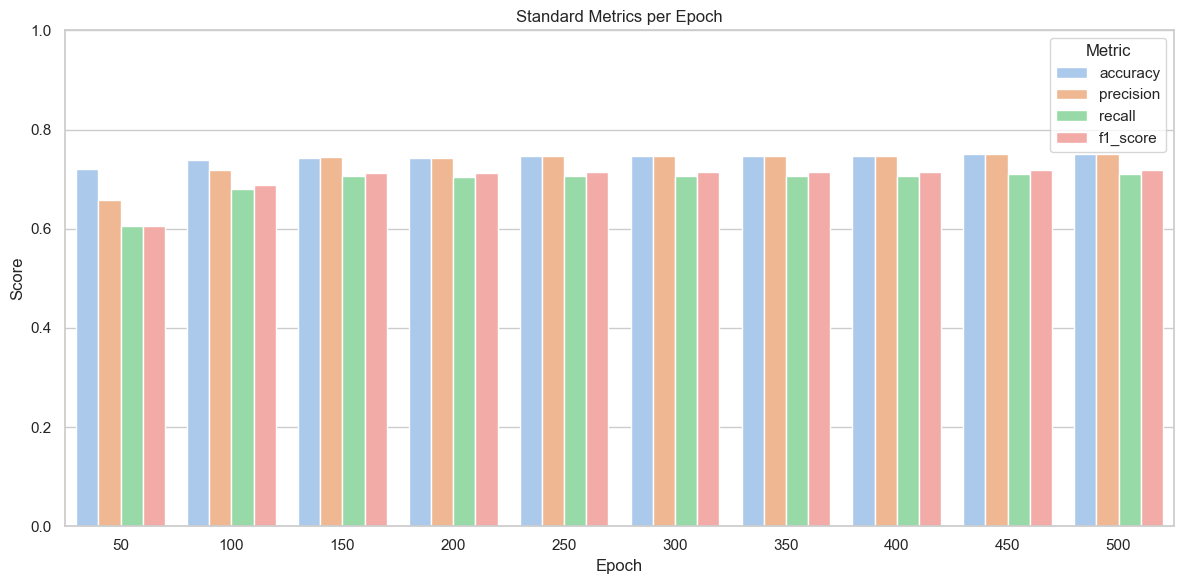

In [4]:
df = pd.DataFrame(results_epoch)

df_metrics = pd.melt(
    df,
    id_vars="epoch",
    value_vars=["accuracy", "precision", "recall", "f1_score"],
    var_name="metric",
    value_name="score"
)

sns.set_theme(style="whitegrid", palette="pastel")

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(ax=ax, x="epoch", y="score", hue="metric", data=df_metrics)
ax.set_title("Standard Metrics per Epoch")
ax.set_ylabel("Score")
ax.set_xlabel("Epoch")
ax.set_ylim(0, 1)
ax.legend(title="Metric")

plt.tight_layout()
plt.show()

Based on the comparison of evaluation metrics across different epoch values, we observed that performance metrics plateau starting from epoch 150. To balance accuracy and training efficiency, we selected the configuration with epoch = 200, which achieved high scores across all metrics while remaining efficient and allso gives a good trainig_time.

In [5]:
results_lr = []

for lr_val in [0.25, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]:
    print(f"Training with lr={lr_val}")
    
    start_train = time.time()
    model = fasttext.train_supervised(
        input="data/train_data.txt",
        lr=lr_val,
        epoch=200,
        wordNgrams=2,
        dim=100,
        loss='softmax'
    )
    train_time = time.time() - start_train

    # Mecure inferance time for each model
    start_infer = time.time()
    y_pred = [model.predict(text)[0][0].replace("__label__", "") for text in val_texts]
    infer_time = time.time() - start_infer

    y_true = val_labels

    # Calculate acuuracy, precision, recall and f1 score
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    results_lr.append({
        'lr': lr_val,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'train_time': train_time,
        'inference_time': infer_time
    })

    print(f"LR={lr_val}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, Train Time={train_time:.2f}s, Inference Time={infer_time:.2f}s")


Training with lr=0.25
LR=0.25: Acc=0.7510, Prec=0.7516, Rec=0.7106, F1=0.7187, Train Time=8.67s, Inference Time=0.02s
Training with lr=0.5
LR=0.5: Acc=0.7552, Prec=0.7530, Rec=0.7128, F1=0.7209, Train Time=9.84s, Inference Time=0.02s
Training with lr=1
LR=1: Acc=0.7531, Prec=0.7481, Rec=0.7135, F1=0.7182, Train Time=10.30s, Inference Time=0.02s
Training with lr=1.5
LR=1.5: Acc=0.7573, Prec=0.7509, Rec=0.7150, F1=0.7204, Train Time=10.21s, Inference Time=0.03s
Training with lr=2
LR=2: Acc=0.7510, Prec=0.7558, Rec=0.7108, F1=0.7195, Train Time=9.23s, Inference Time=0.02s
Training with lr=2.5
LR=2.5: Acc=0.7573, Prec=0.7192, Rec=0.7102, F1=0.7093, Train Time=8.14s, Inference Time=0.02s
Training with lr=3
LR=3: Acc=0.7573, Prec=0.7209, Rec=0.7097, F1=0.7024, Train Time=8.19s, Inference Time=0.02s
Training with lr=3.5
LR=3.5: Acc=0.7469, Prec=0.7113, Rec=0.7030, F1=0.6929, Train Time=8.30s, Inference Time=0.02s
Training with lr=4
LR=4: Acc=0.7469, Prec=0.7452, Rec=0.7033, F1=0.7095, Train T

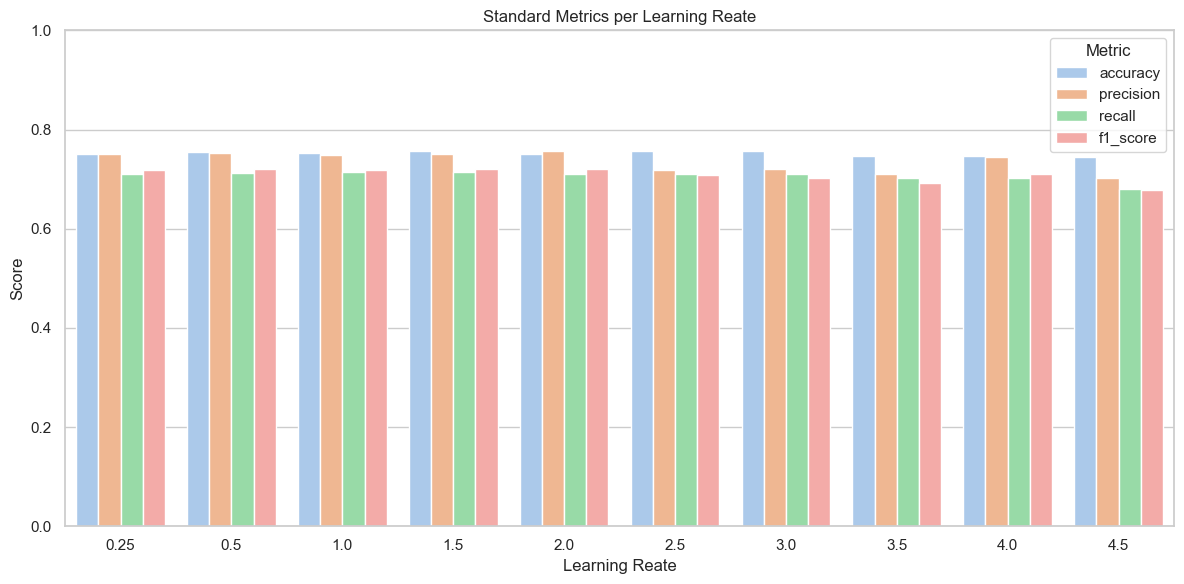

In [6]:
df = pd.DataFrame(results_lr)

df_metrics = pd.melt(
    df,
    id_vars="lr",
    value_vars=["accuracy", "precision", "recall", "f1_score"],
    var_name="metric",
    value_name="score"
)

sns.set_theme(style="whitegrid", palette="pastel")

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(ax=ax, x="lr", y="score", hue="metric", data=df_metrics)
ax.set_title("Standard Metrics per Learning Reate")
ax.set_ylabel("Score")
ax.set_xlabel("Learning Reate")
ax.set_ylim(0, 1)
ax.legend(title="Metric")

plt.tight_layout()
plt.show()

Multiple values for the learning rate were evaluated, ranging from 0.25 to 4.5. Results show that the model performs optimally between 1.0 and 2.0. While higher values maintained acceptable performance, the most consistent and balanced metrics were achieved at lr = 1.5, which was selected for the final model.

In [7]:
results_dim = []

for dim_val in [10, 20, 30, 50, 75, 100, 150, 200, 250, 300]:
    print(f"Training with dim={dim_val}")
    
    start_train = time.time()
    model = fasttext.train_supervised(
        input="data/train_data.txt",
        lr=1.5,
        epoch=200,
        wordNgrams=2,
        dim=dim_val,
        loss='softmax'
    )
    train_time = time.time() - start_train

    # Mecure inferance time for each model
    start_infer = time.time()
    y_pred = [model.predict(text)[0][0].replace("__label__", "") for text in val_texts]
    infer_time = time.time() - start_infer

    y_true = val_labels

    # Calculate acuuracy, precision, recall and f1 score
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    results_dim.append({
        'dim': dim_val,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'train_time': train_time,
        'inference_time': infer_time
    })

    print(f"Dim={dim_val}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, Train Time={train_time:.2f}s, Inference Time={infer_time:.2f}s")


Training with dim=10
Dim=10: Acc=0.7573, Prec=0.7398, Rec=0.7106, F1=0.7130, Train Time=2.35s, Inference Time=0.02s
Training with dim=20
Dim=20: Acc=0.7615, Prec=0.7441, Rec=0.7150, F1=0.7186, Train Time=3.12s, Inference Time=0.03s
Training with dim=30
Dim=30: Acc=0.7615, Prec=0.7620, Rec=0.7240, F1=0.7308, Train Time=3.69s, Inference Time=0.02s
Training with dim=50
Dim=50: Acc=0.7699, Prec=0.7696, Rec=0.7325, F1=0.7396, Train Time=5.18s, Inference Time=0.02s
Training with dim=75
Dim=75: Acc=0.7573, Prec=0.7567, Rec=0.7149, F1=0.7233, Train Time=6.81s, Inference Time=0.02s
Training with dim=100
Dim=100: Acc=0.7594, Prec=0.7502, Rec=0.7176, F1=0.7212, Train Time=8.13s, Inference Time=0.02s
Training with dim=150
Dim=150: Acc=0.7636, Prec=0.7593, Rec=0.7311, F1=0.7377, Train Time=11.12s, Inference Time=0.03s
Training with dim=200
Dim=200: Acc=0.7594, Prec=0.7588, Rec=0.7193, F1=0.7270, Train Time=14.32s, Inference Time=0.04s
Training with dim=250
Dim=250: Acc=0.7573, Prec=0.7524, Rec=0.72

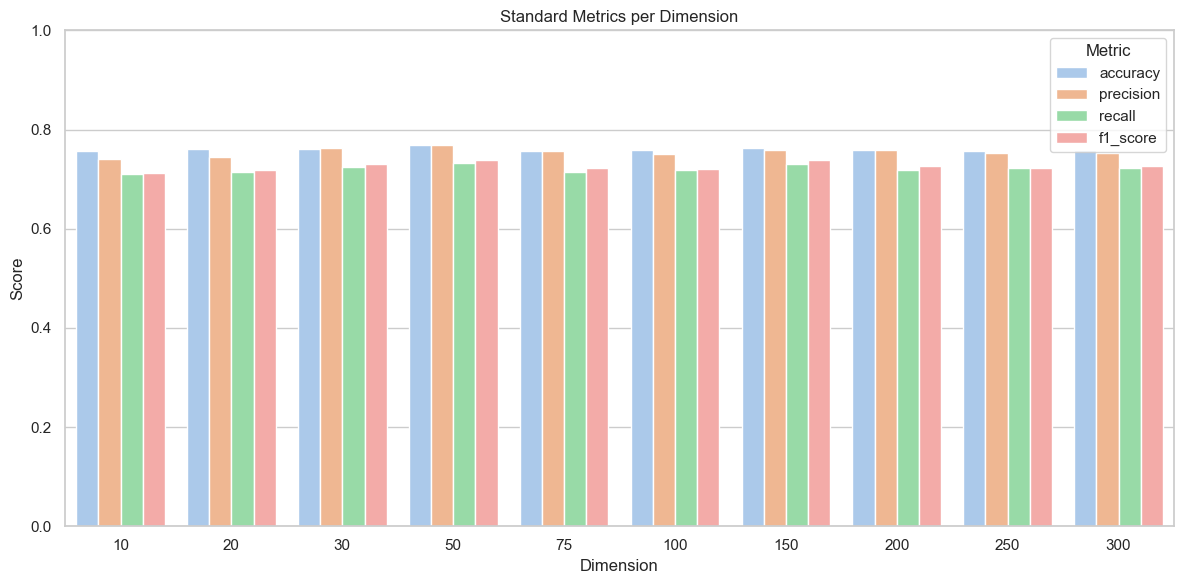

In [8]:
df = pd.DataFrame(results_dim)

df_metrics = pd.melt(
    df,
    id_vars="dim",
    value_vars=["accuracy", "precision", "recall", "f1_score"],
    var_name="metric",
    value_name="score"
)

sns.set_theme(style="whitegrid", palette="pastel")

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(ax=ax, x="dim", y="score", hue="metric", data=df_metrics)
ax.set_title("Standard Metrics per Dimension")
ax.set_ylabel("Score")
ax.set_xlabel("Dimension")
ax.set_ylim(0, 1)
ax.legend(title="Metric")

plt.tight_layout()
plt.show()

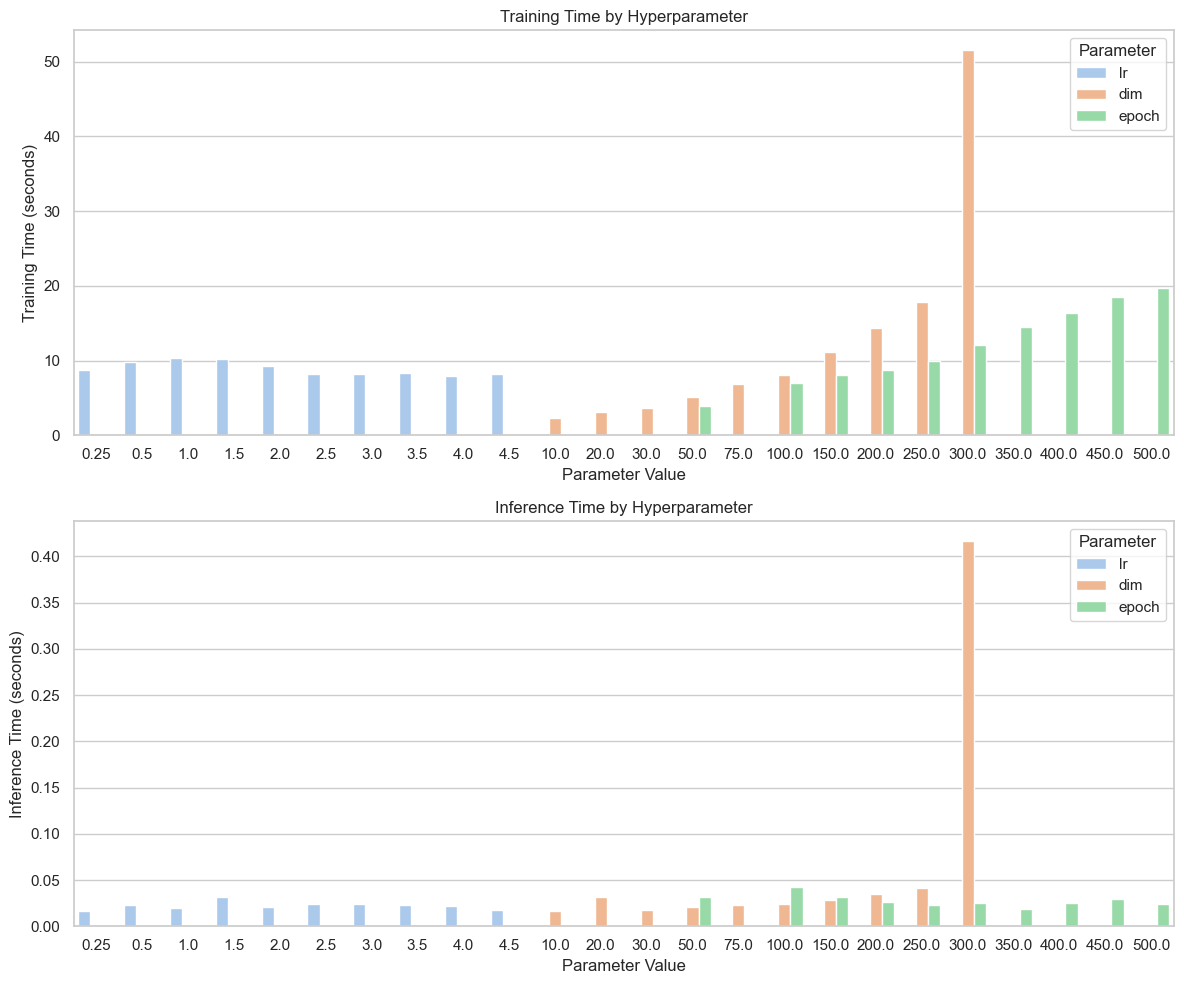

In [9]:
df_epoch = pd.DataFrame(results_epoch)
df_epoch["param_type"] = "epoch"
df_epoch["param_value"] = df_epoch["epoch"]

df_lr = pd.DataFrame(results_lr)
df_lr["param_type"] = "lr"
df_lr["param_value"] = df_lr["lr"]

df_dim = pd.DataFrame(results_dim)
df_dim["param_type"] = "dim"
df_dim["param_value"] = df_dim["dim"]

df_all = pd.concat([df_epoch, df_lr, df_dim], ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

sns.set_theme(style="whitegrid", palette="pastel")

sns.barplot(ax=axes[0], x="param_value", y="train_time", hue="param_type", data=df_all)
axes[0].set_title("Training Time by Hyperparameter")
axes[0].set_xlabel("Parameter Value")
axes[0].set_ylabel("Training Time (seconds)")
axes[0].legend(title="Parameter")

sns.barplot(ax=axes[1], x="param_value", y="inference_time", hue="param_type", data=df_all)
axes[1].set_title("Inference Time by Hyperparameter")
axes[1].set_xlabel("Parameter Value")
axes[1].set_ylabel("Inference Time (seconds)")
axes[1].legend(title="Parameter")

plt.tight_layout()
plt.show()

As the embedding dimension increased, model performance improved slightly up to dim = 100, then plateaued. Meanwhile, training time grew consistently. Therefore, dim = 75 offers an optimal balance between accuracy and computational efficiency.

### Random Seeds Training

To evaluate the model’s stability, I trained it 10 times using the same dataset but with different random seeds to shuffle the training examples. This ensured that the model saw slightly different data orders at each run.

In [10]:
results = []

for seed in range(10):
    with open("data/train_data.txt", "r", encoding="utf-8") as f:
        lines = f.readlines()

    np.random.seed(seed)
    np.random.shuffle(lines)

    temp_file = f"data/train_temp_{seed}.txt"
    with open(temp_file, "w", encoding="utf-8") as f:
        f.writelines(lines)

    start_train = time.time()
    model = fasttext.train_supervised(
        input=temp_file,
        lr=1.5,
        epoch=200,
        wordNgrams=2,
        dim=100,
        loss='softmax'
    )
    end_train = time.time()
    train_time = end_train - start_train

    start_inf = time.time()
    y_pred = [model.predict(text)[0][0].replace("__label__", "") for text in val_texts]
    end_inf = time.time()
    inference_time = end_inf - start_inf

    acc = accuracy_score(val_labels, y_pred)
    prec = precision_score(val_labels, y_pred, average="macro", zero_division=0)
    rec = recall_score(val_labels, y_pred, average="macro", zero_division=0)
    f1 = f1_score(val_labels, y_pred, average="macro", zero_division=0)

    results.append({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "train_time": train_time,
        "inference_time": inference_time
    })

In [11]:
results_df = pd.DataFrame(results)
results_df.loc["mean"] = results_df.mean(numeric_only=True)
results_df.loc["std"] = results_df.std(numeric_only=True)
print(results_df)

      accuracy  precision    recall  f1_score  train_time  inference_time
0     0.757322   0.757495  0.715739  0.724060    8.758561        0.029978
1     0.763598   0.742156  0.710698  0.714694    8.360511        0.020904
2     0.759414   0.752862  0.712010  0.718986    7.910519        0.022531
3     0.759414   0.756356  0.726032  0.730613    8.025185        0.020236
4     0.759414   0.737504  0.707705  0.711257    7.996636        0.022173
5     0.755230   0.729323  0.708459  0.707147    8.388472        0.027853
6     0.757322   0.739366  0.710922  0.714387    8.214254        0.022070
7     0.759414   0.760730  0.715915  0.724525    8.241127        0.028887
8     0.757322   0.757736  0.720117  0.727259    8.716299        0.023000
9     0.763598   0.762315  0.731944  0.738899    7.831836        0.022989
mean  0.759205   0.749584  0.715954  0.721183    8.244340        0.024062
std   0.002554   0.010899  0.007532  0.009208    0.302215        0.003308


In [12]:
with open("data/train_data.txt", "r", encoding="utf-8") as f:
    train_lines = f.readlines()

texts = [line.strip().split(' ', 1)[1] for line in train_lines]
labels = [line.strip().split(' ', 1)[0].replace("__label__", "") for line in train_lines]

In [13]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
metrics_per_fold = []

def save_fasttext_format(X, y, path):
    with open(path, "w", encoding="utf-8") as f:
        for text, label in zip(X, y):
            f.write(f"__label__{label} {text}\n")

### K-Fold Cross-Validation

To ensure a more reliable and generalizable evaluation, we applied Stratified K-Fold Cross-Validation with 10 folds. In each fold, the training set was further split into 90% training and 10% validation data using stratification and random seeding. 

In [14]:
metrics_per_fold = []
fold = 0

for train_idx, test_idx in skf.split(texts, labels):
    fold += 1
    X_train_full = [texts[i] for i in train_idx]
    y_train_full = [labels[i] for i in train_idx]
    X_test = [texts[i] for i in test_idx]
    y_test = [labels[i] for i in test_idx]

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.1, stratify=y_train_full, random_state=fold
    )

    train_file = tempfile.NamedTemporaryFile(delete=False, mode='w+', encoding='utf-8', suffix='.txt')
    val_file = tempfile.NamedTemporaryFile(delete=False, mode='w+', encoding='utf-8', suffix='.txt')
    save_fasttext_format(X_train, y_train, train_file.name)
    save_fasttext_format(X_val, y_val, val_file.name)

    # Timp de antrenare
    start_train = time.time()
    model = fasttext.train_supervised(
        input=train_file.name,
        lr=1.5,
        epoch=200,
        wordNgrams=2,
        dim=100,
        loss='softmax'
    )
    end_train = time.time()
    train_time = end_train - start_train

    # Timp de inferență
    start_inf = time.time()
    y_pred = [model.predict(text)[0][0].replace("__label__", "") for text in X_val]
    end_inf = time.time()
    inference_time = end_inf - start_inf

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_val, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)

    metrics_per_fold.append({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "train_time": train_time,
        "inference_time": inference_time
    })

    train_file.close()
    val_file.close()
    os.unlink(train_file.name)
    os.unlink(val_file.name)

In [15]:
metrics_df = pd.DataFrame(metrics_per_fold)
metrics_df.loc["mean"] = metrics_df.mean(numeric_only=True)
metrics_df.loc["std"] = metrics_df.std(numeric_only=True)
print(metrics_df)

      accuracy  precision    recall  f1_score  train_time  inference_time
0     0.764858   0.758636  0.707066  0.716836    7.062937        0.015990
1     0.733850   0.701391  0.673105  0.675775    6.827974        0.017942
2     0.762274   0.741021  0.699173  0.698378    6.635914        0.023502
3     0.739018   0.731394  0.689957  0.695907    6.731591        0.023634
4     0.764858   0.713861  0.689600  0.691974    6.722451        0.023761
5     0.751938   0.710138  0.694834  0.694462    6.503352        0.022552
6     0.751938   0.754643  0.680756  0.699866    6.740144        0.024083
7     0.744186   0.713333  0.708829  0.704237    6.849648        0.024935
8     0.782946   0.740657  0.722082  0.719624    6.539570        0.012767
9     0.682171   0.636839  0.632160  0.617436    6.647215        0.020968
mean  0.747804   0.720191  0.689756  0.691449    6.726080        0.021013
std   0.025793   0.033365  0.023449  0.027338    0.154308        0.003879


In [16]:
model = fasttext.train_supervised(
    input="data/train_data.txt",
    lr=1.5,
    epoch=200,
    wordNgrams=2,
    dim=100,
    loss='softmax'
)

In [17]:
model.test("data/test_data.txt")

(1195, 0.7364016736401674, 0.7364016736401674)

In [ ]:
model.save_model("final_model.bin")